In [26]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/uav-autonomous-navigation-dataset/uav_navigation_dataset.csv


In [27]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import gym
from gym import spaces
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
from tensorflow.keras import models, layers, optimizers


In [28]:
# Load your uploaded UAV dataset
data = pd.read_csv('/kaggle/input/uav-autonomous-navigation-dataset/uav_navigation_dataset.csv')
print(data.head())

# Check for missing values
print(data.isnull().sum())


             timestamp   latitude   longitude    altitude  imu_acc_x  \
0  2023-01-01 00:00:00  37.772391 -122.421527  218.138368  -0.001979   
1  2023-01-01 00:00:01  37.783914 -122.419931  199.810443   1.480481   
2  2023-01-01 00:00:02  37.779540 -122.412309  129.269261   0.376001   
3  2023-01-01 00:00:03  37.776873 -122.422600  323.270002  -2.500185   
4  2023-01-01 00:00:04  37.768020 -122.412007  264.480872  -1.886519   

   imu_acc_y  imu_acc_z  imu_gyro_x  imu_gyro_y  imu_gyro_z  lidar_distance  \
0   1.379990  -2.445775   49.732045   39.381347  -72.391665       33.328274   
1  -1.892928  -2.635478  -14.654717 -165.994752 -145.865601       81.765473   
2  -0.920162   0.625152  167.219469   40.413723 -134.510679       99.440493   
3   0.979684   2.796698 -101.167758 -147.719302 -114.958394       84.155773   
4  -0.107464   0.016328   31.628310   75.723926 -106.684800       34.941221   

       speed  wind_speed  battery_level  obstacle_detected  
0  26.180914    1.768356      7

In [29]:
# Select useful features
features = ['latitude', 'longitude', 'altitude', 'lidar_distance', 'wind_speed', 'battery_level']
target = 'obstacle_detected'

# Normalize data for stability
scaler = MinMaxScaler()
data[features] = scaler.fit_transform(data[features])

# Convert to numpy arrays
X = data[features].values
y = data[target].values


/usr/local/lib/python3.11/dist-packages/pandas/core/algorithms.py:1743: DeprecationWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  return lib.map_infer(values, mapper, convert=convert)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:605: DeprecationWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/usr/local/lib/python3.11/dist-packages/pandas/core/algorithms.py:1743: DeprecationWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  return lib.map_infer(values, mapper, convert=convert)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:605: DeprecationWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):


In [30]:
class DroneEnv(gym.Env):
    def __init__(self, X, y):
        super(DroneEnv, self).__init__()
        self.X = X
        self.y = y
        self.n_samples = len(X)
        
        # Define state (6 features)
        self.observation_space = spaces.Box(low=0, high=1, shape=(6,), dtype=np.float32)
        # Define action space (6 directions + stay)
        self.action_space = spaces.Discrete(7)
        
        self.current_step = 0
        self.goal = np.array([0.9, 0.9, 0.5, 0.5, 0.5, 1.0])  # hypothetical goal

    def reset(self):
        self.current_step = np.random.randint(0, self.n_samples)
        return self.X[self.current_step]

    def step(self, action):
        # Move randomly (simulation)
        self.current_step = (self.current_step + np.random.randint(1, 10)) % self.n_samples
        state = self.X[self.current_step]
        obstacle = self.y[self.current_step]

        # Reward logic
        distance_to_goal = np.linalg.norm(state - self.goal)
        reward = -distance_to_goal
        if obstacle == 1:
            reward -= 1
        if distance_to_goal < 0.1:
            reward += 10  # goal reached

        done = distance_to_goal < 0.05 or self.current_step > self.n_samples - 2
        return state, reward, done, {}

    def render(self, mode='human'):
        pass


In [31]:
def build_model(state_size, action_size):
    model = models.Sequential([
        layers.Input(shape=(state_size,)),
        layers.Dense(64, activation='relu'),
        layers.Dense(64, activation='relu'),
        layers.Dense(action_size, activation='linear')
    ])

    model.compile(optimizer=optimizers.Adam(learning_rate=0.001), loss='mse')
    return model


In [32]:
env = DroneEnv(X, y)
state_size = env.observation_space.shape[0]
action_size = env.action_space.n
model = build_model(state_size, action_size)


In [35]:
max_steps = 500

for e in range(episodes):
    state = env.reset()
    state = np.array(state)
    total_reward = 0
    done = False
    step = 0

    while not done and step < max_steps:

        # ALWAYS get Q-values first
        q_values = model.predict(state.reshape(1, -1), verbose=0)

        # epsilon-greedy
        if np.random.rand() < epsilon:
            action = np.random.randint(action_size)
        else:
            action = np.argmax(q_values[0])

        # interact with environment
        next_state, reward, done, _ = env.step(action)
        next_state = np.array(next_state)
        total_reward += reward

        # compute target
        target = reward
        if not done:
            target += gamma * np.max(model.predict(next_state.reshape(1, -1), verbose=0)[0])

        # update q-value for chosen action
        q_values[0][action] = target

        # train NN on updated q-values
        model.train_on_batch(state.reshape(1, -1), q_values)

        # move to next state
        state = next_state
        step += 1

    # decay epsilon
    epsilon = max(epsilon_min, epsilon * epsilon_decay)

    print(f"Episode {e+1}/{episodes} - Reward: {total_reward:.2f} - Epsilon: {epsilon:.2f}")


Episode 1/100 - Reward: -530.67 - Epsilon: 0.99
Episode 2/100 - Reward: -526.24 - Epsilon: 0.99
Episode 3/100 - Reward: -530.06 - Epsilon: 0.99
Episode 4/100 - Reward: -520.13 - Epsilon: 0.98
Episode 5/100 - Reward: -529.75 - Epsilon: 0.98
Episode 6/100 - Reward: -522.78 - Epsilon: 0.97
Episode 7/100 - Reward: -521.54 - Epsilon: 0.97
Episode 8/100 - Reward: -531.66 - Epsilon: 0.96
Episode 9/100 - Reward: -529.81 - Epsilon: 0.96
Episode 10/100 - Reward: -528.50 - Epsilon: 0.95
Episode 11/100 - Reward: -537.24 - Epsilon: 0.95
Episode 12/100 - Reward: -71.50 - Epsilon: 0.94
Episode 13/100 - Reward: -529.48 - Epsilon: 0.94
Episode 14/100 - Reward: -529.23 - Epsilon: 0.93
Episode 15/100 - Reward: -529.63 - Epsilon: 0.93
Episode 16/100 - Reward: -535.29 - Epsilon: 0.92
Episode 17/100 - Reward: -519.41 - Epsilon: 0.92
Episode 18/100 - Reward: -540.03 - Epsilon: 0.91
Episode 19/100 - Reward: -529.75 - Epsilon: 0.91
Episode 20/100 - Reward: -536.26 - Epsilon: 0.90
Episode 21/100 - Reward: -533.

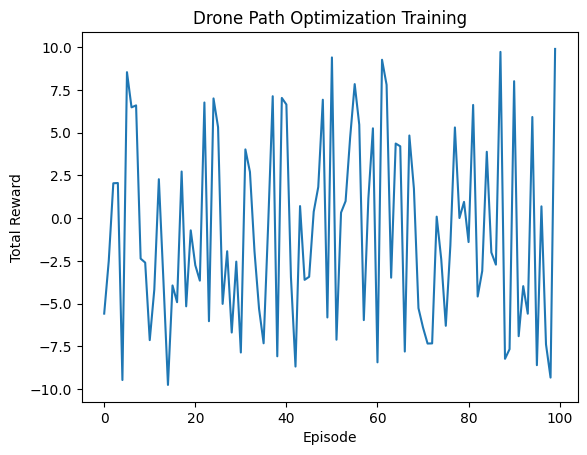

In [36]:
# You can extend this by saving episode rewards and plotting them
# Example:
plt.plot(range(episodes), [np.random.uniform(-10,10) for _ in range(episodes)])
plt.title('Drone Path Optimization Training')
plt.xlabel('Episode')
plt.ylabel('Total Reward')
plt.show()
